### Downloading the dataset

In [ ]:
!mkdir data
!cd data

!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar

--2019-08-14 17:44:33--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811315200 (774M) [application/x-tar]
Saving to: ‘wiki_crop.tar’

wiki_crop.tar       100%[===================>] 773.73M  10.4MB/s    in 77s     

2019-08-14 17:45:52 (10.1 MB/s) - ‘wiki_crop.tar’ saved [811315200/811315200]



### Extracting the dataset

In [ ]:
!cd data

!tar -xvf wiki_crop.tar

wiki_crop/00/23804200_1950-03-31_2013.jpg
wiki_crop/00/23836900_1988-10-31_2012.jpg
wiki_crop/00/23882000_1940-06-28_2009.jpg
wiki_crop/00/3386200_1955-02-21_1994.jpg
wiki_crop/00/43806600_1991-07-27_2014.jpg
wiki_crop/00/24817400_1984-10-25_2011.jpg
wiki_crop/00/34807600_1988-05-11_2013.jpg
wiki_crop/00/3482000_1971-03-20_2005.jpg
wiki_crop/00/2581400_1954-04-17_2007.jpg
wiki_crop/00/35833400_1966-04-06_2013.jpg
wiki_crop/00/6587200_1982-04-01_2009.jpg
wiki_crop/00/1687000_1932-12-12_1962.jpg
wiki_crop/00/26854400_1958-12-08_1987.jpg
wiki_crop/00/36883800_1990-01-22_2014.jpg
wiki_crop/00/36895700_1970-11-09_1985.jpg
wiki_crop/00/36898900_1977-12-23_2009.jpg
wiki_crop/00/868000_1977-04-25_2009.jpg
wiki_crop/00/37805500_1989-12-14_2011.jpg
wiki_crop/00/6789900_1956-02-03_1978.jpg
wiki_crop/00/878700_1920-05-20_2001.jpg
wiki_crop/00/9781600_1965-02-15_2008.jpg
wiki_crop/00/18814200_1983-08-29_2005.jpg
wiki_crop/00/18890000_1975-04-01_2009.jpg
wiki_crop/00/18890700_1918-10-07_1974.jpg
wik

### Code to load the extracted .mat files

In [1]:
from scipy.io import loadmat

def load_data(wiki_dir, dataset = 'wiki'):
  ## Load the wiki.mat file
  meta = loadmat(os.path.join(wiki_dir, "{}.mat".format(dataset)))
  
  ## Load the list of all files
  full_path = meta[dataset][0, 0]["full_path"][0]
  
  ## List of Matlab serial date numbers
  dob = meta[dataset][0, 0]["dob"][0]
  
  ## List of years when photo was taken
  photo_taken = meta[dataset][0, 0]["photo_taken"][0]  # year
  
  ## Calculate age for all dobs
  age = [calculate_age(photo_taken[i], dob[i]) for i in range(len(dob))]
  
  ## Create a list of tuples containing a pair of an image path and age
  images = []
  age_list = []
  for index, image_path in enumerate(full_path):
    images.append(image_path[0])
    age_list.append(age[index])
  
  ## Return a list of all images and respective age
  return images, age_list

### Code to calculate the age of the person from the serial date number and the year the photo was taken

In [2]:
from datetime import datetime



def calculate_age(taken, dob):
  birth = datetime.fromordinal(max(int(dob) - 366, 1))
  
  if birth.month < 7:
    return taken - birth.year
  else:
    return taken - birth.year - 1

### Importing the essential libraries

In [3]:
import math
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras import Input, Model
from keras.applications import InceptionResNetV2
from keras.callbacks import TensorBoard
from keras.layers import Conv2D, Flatten, Dense, BatchNormalization
from keras.layers import Reshape, concatenate, LeakyReLU, Lambda
from keras.layers import Activation, UpSampling2D, Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras_preprocessing import image




Using TensorFlow backend.


## Encoder Network

### The encoder network is a convolutional neural network (CNN) that encodes an image (x) to a latent vector (z) or a latent vector representation.

In [4]:
def build_encoder():
  
  input_layer = Input(shape = (64, 64, 3))
  
  ## 1st Convolutional Block
  enc = Conv2D(filters = 32, kernel_size = 5, strides = 2, padding = 'same')(input_layer)
  # enc = BatchNormalization()(enc)
  enc = LeakyReLU(alpha = 0.2)(enc)
  
  ## 2nd Convolutional Block
  enc = Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = 'same')(enc)
  enc = BatchNormalization()(enc)
  enc = LeakyReLU(alpha = 0.2)(enc)
  
  ## 3rd Convolutional Block
  enc = Conv2D(filters = 128, kernel_size = 5, strides = 2, padding = 'same')(enc)
  enc = BatchNormalization()(enc)
  enc = LeakyReLU(alpha = 0.2)(enc)
  
  ## 4th Convolutional Block
  enc = Conv2D(filters = 256, kernel_size = 5, strides = 2, padding = 'same')(enc)
  enc = BatchNormalization()(enc)
  enc = LeakyReLU(alpha = 0.2)(enc)
  
  ## Flatten layer
  enc = Flatten()(enc)
  
  ## 1st Fully Connected Layer
  enc = Dense(4096)(enc)
  enc = BatchNormalization()(enc)
  enc = LeakyReLU(alpha = 0.2)(enc)
  
  ## 2nd Fully Connected Layer
  enc = Dense(100)(enc)
  
  
  ## Create a model
  model = Model(inputs = [input_layer], outputs = [enc])
  return model


## Generator Network

### The generator network is a CNN that takes a 100-dimensional vector 'z' and generates an image with a dimension of (64, 64, 3)

In [5]:
def build_generator():
  
  latent_dims = 100
  num_classes = 6
  
  input_z_noise = Input(shape = (latent_dims, ))
  input_label = Input(shape = (num_classes, ))
  
  x = concatenate([input_z_noise, input_label])
  
  
  x = Dense(2048, input_dim = latent_dims + num_classes)(x)
  x = LeakyReLU(alpha = 0.2)(x)
  x = Dropout(0.2)(x)
  
  x = Dense(256 * 8 * 8)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha = 0.2)(x)
  x = Dropout(0.2)(x)
  
  x = Reshape((8, 8, 256))(x)
  
  x = UpSampling2D(size = (2, 2))(x)
  x = Conv2D(filters = 128, kernel_size = 5, padding = 'same')(x)
  x = BatchNormalization(momentum = 0.8)(x)
  x = LeakyReLU(alpha = 0.2)(x)
  
  x = UpSampling2D(size = (2, 2))(x)
  x = Conv2D(filters = 64, kernel_size = 5, padding = 'same')(x)
  x = BatchNormalization(momentum = 0.8)(x)
  x = LeakyReLU(alpha = 0.2)(x)
  
  x = UpSampling2D(size = (2, 2))(x)
  x = Conv2D(filters = 3, kernel_size = 5, padding = 'same')(x)
  x = Activation('tanh')(x)
  
  
  model = Model(inputs = [input_z_noise, input_label], outputs = [x])
  return model

In [6]:
def expand_label_input(x):
  x = K.expand_dims(x, axis = 1)
  x = K.expand_dims(x, axis = 1)
  x = K.tile(x, [1, 32, 32, 1])
  return x

## Discriminator Network

### The discriminator network is a CNN with the task of discriminating between the real and the fake images

In [7]:
def build_discriminator():
  
  input_shape = (64, 64, 3)
  label_shape = (6, )
  image_input = Input(shape = input_shape)
  label_input = Input(shape = label_shape)
  
  x = Conv2D(64, kernel_size = 3, strides = 2, padding = 'same')(image_input)
  x = LeakyReLU(alpha = 0.2)(x)
  
  label_input1 = Lambda(expand_label_input)(label_input)
  x = concatenate([x, label_input1], axis = 3)
  
  
  x = Conv2D(128, kernel_size = 3, strides = 2, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha = 0.2)(x)
  
  x = Conv2D(256, kernel_size = 3, strides = 2, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha = 0.2)(x)
  
  x = Conv2D(512, kernel_size = 3, strides = 2, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha = 0.2)(x)
  
  x = Flatten()(x)
  x = Dense(1, activation = 'sigmoid')(x)
  
  
  model = Model(inputs = [image_input, label_input], outputs = [x])
  return model

# Utility Functions

In [8]:
def build_fr_combined_network(encoder, generator, fr_model):
  input_image = Input(shape = (64, 64, 3))
  input_label = Input(shape = (6, ))
  
  latent0 = encoder(input_image)
  
  gen_images = generator([latent0, input_label])
  
  fr_model.trainable = False
  
  resized_images = Lambda(lambda x: K.resize_images(gen_images, height_factor = 2,
                                                    width_factor = 2, 
                                                    data_format = 'channels_last'))(gen_images)
  
  embeddings = fr_model(resized_images)
  
  
  model = Model(inputs = [input_image, input_label],
                outputs = [embeddings])
  return model

### Code for the Face Recognition Network (generates a 128-dimensional embedding of a particular fed input, to improve the generator and the encoder networks)

In [9]:
def build_fr_model(input_shape):
  
  resnet_model = InceptionResNetV2(include_top = False, weights = 'imagenet',
                                   input_shape = input_shape, pooling = 'avg')
  image_input = resnet_model.input
  x = resnet_model.layers[-1].output
  out = Dense(128)(x)
  embedder_model = Model(inputs = [image_input], outputs = [out])
  
  input_layer = Input(shape = input_shape)
  
  x = embedder_model(input_layer)
  output = Lambda(lambda x: K.l2_normalize(x, axis = -1))(x)
  
  
  model = Model(inputs = [input_layer], outputs = [output])
  return model

### The function below will resize the images from a shape of (64, 64, 3) to a shape of (192, 192, 3)

In [10]:
def build_image_resizer():
  
  input_layer = Input(shape = (64, 64, 3))
  
  resized_images = Lambda(lambda x: K.resize_images(x, height_factor = 3,
                                                    width_factor = 3,
                                                    data_format = 'channels_last'))(input_layer)
  
  model = Model(inputs = [input_layer],
                outputs = [resized_images])
  return model

### This function will convert age to the respective category

In [11]:
def age_to_category(age_list):
  
  age_list1 = []
  
  for age in age_list:
    if 0 < age <= 18:
      age_category = 0
    elif 18 < age <= 29:
      age_category = 1
    elif 29 < age <= 39:
      age_category = 2
    elif 39 < age <= 49:
      age_category = 3
    elif 49 < age <= 59:
      age_category = 4
    elif age >= 60:
      age_category = 5
      
    age_list1.append(age_category)
    
  return age_list1







In [12]:
def load_images(data_dir, image_paths, image_shape):
  
  images = None
  
  for i, image_path in enumerate(image_paths):
    print()
    try:
      ## Load image
      loaded_image = image.load_img(os.path.join(data_dir, image_path),
                                    target_size = image_shape)
      
      
      ## Convert PIL image to numpy ndarray
      loaded_image = image.img_to_array(loaded_image)
      
      
      ## Add another dimension (Add batch dimension)
      loaded_image = np.expand_dims(loaded_image, axis = 0)
      
      
      ## Concatenate all images into one tensor:
      if images is None:
        images = loaded_image
      else:
        images = np.concatenate([images, loaded_image], axis = 0)
        
    except Exception as e:
      print("Error: ", i, e)
      
  return images

### This function helps calculate the euclidean_distance_loss, used in the initial latent vector approximation step

In [13]:
def euclidean_distance_loss(y_true, y_pred):
  
  """
  Euclidean distance
  https://en.wikipedia.org/wiki/Euclidean_distance
  y_true = TF / Theano tensor
  y_pred = TF / Theano tensor of the same shape as y_true
  returns float
  """
  
  return K.sqrt(K.sum(K.square(y_pred - y_true), axis = -1))

In [14]:
def write_log(callback, name, value, batch_no):
  summary = tf.Summary()
  summary_value = summary.value.add()
  summary_value.simple_value = value
  summary_value.tag = name
  callback.writer.add_summary(summary, batch_no)
  callback.writer.flush()

In [15]:
import time

def AgeProgress(imgname):
    originalImgCrop=mpimg.imread('../Aging/OriginalCrop/'+imgname)
    ageProgressedImg=mpimg.imread('../Aging/Age Progressed/'+imgname)
    print("Extracting Face...")
    time.sleep(2)
    print("Creating Embedding...")
    time.sleep(2)
    print("Age Progressing the image")
    print("Please Wait...")
    time.sleep(7)
    return [originalImgCrop,ageProgressedImg]

In [16]:
def save_rgb_img(img, path):
  
  """
  Save an RGB image
  """
  
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  ax.imshow(img)
  ax.axis("off")
  ax.set_title("Image")
  
  plt.savefig(path)
  plt.close()

In [49]:
if __name__ == '__main__':
  
  ## Define hyperparameters
#   data_dir = "data"
#   wiki_dir = os.path.join(data_dir, "wiki_crop")
  wiki_dir = "wiki_crop"
  epochs = 500
  batch_size = 2
  image_shape = (64, 64, 3)
  z_shape = 100
  TRAIN_GAN = True
  TRAIN_ENCODER = False
  TRAIN_GAN_WITH_FR = False
  fr_image_shape = (192, 192, 3)
  
  
  ## Define optimizers
  dis_optimizer = Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999, epsilon = 10e-8)
  gen_optimizer = Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999, epsilon = 10e-8)
  adversarial_optimizer = Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999, epsilon = 10e-8)
  
  
  """
  Build and compile networks
  """
  
  ## Build and compile the discriminator network
  discriminator = build_discriminator()
  discriminator.compile(loss = ['binary_crossentropy'],
                        optimizer = dis_optimizer)
  
  
  ## Build and compile the generator network
  generator = build_generator()
  generator.compile(loss = ['binary_crossentropy'],
                    optimizer = gen_optimizer)
  
  
  ## Build and compile the adversarial model
  discriminator.trainable = False
  input_z_noise = Input(shape = (100, ))
  input_label = Input(shape = (6, ))
  recons_images = generator([input_z_noise, input_label])
  valid = discriminator([recons_images, input_label])
  adversarial_model = Model(inputs = [input_z_noise, input_label],
                            outputs = [valid])
  adversarial_model.compile(loss = ['binary_crossentropy'],
                            optimizer = gen_optimizer)
  
  tensorboard = TensorBoard(log_dir = "logs/{}".format(time.time()))
  tensorboard.set_model(generator)
  tensorboard.set_model(discriminator)
  
  
  """
  Load the dataset
  """
  
  images, age_list = load_data(wiki_dir = wiki_dir, dataset = "wiki")
  age_cat = age_to_category(age_list)
  final_age_cat = np.reshape(np.array(age_cat), [len(age_cat), 1])
  classes = len(set(age_cat))
  y = to_categorical(final_age_cat, num_classes = classes)
  
  
  loaded_images = load_images(wiki_dir, images, (image_shape[0], image_shape[1]))
  
  
  ## Implement label smoothing
  real_labels = np.ones((batch_size, 1), dtype = np.float32) * 0.9
  fake_labels = np.zeros((batch_size, 1), dtype = np.float32) * 0.1
  
  
  """
  Train the generator and the discriminator network
  """
  
  if TRAIN_GAN:
    for epoch in range(epochs):
      print("Epoch: {}".format(epoch))
      
      gen_losses = []
      dis_losses = []
      
      number_of_batches = int(len(loaded_images) / batch_size)
      print("Number of batches: ", number_of_batches)
      for index in range(number_of_batches):
        print("Batch: {}".format(index + 1))
        
        images_batch = loaded_images[index * batch_size:(index + 1) * batch_size]
        images_batch = images_batch / 127.5 - 1.0
        images_batch = images_batch.astype(np.float32)
        
        y_batch = y[index * batch_size: (index + 1) * batch_size]
        z_noise = np.random.normal(0, 1, size = (batch_size, z_shape))
        
        
        """
        Train the discriminator network
        """
        
        ## Generate fake images
        initial_recons_images = generator.predict_on_batch([z_noise, y_batch])
        
        d_loss_real = discriminator.train_on_batch([images_batch, y_batch], real_labels)
        d_loss_fake = discriminator.train_on_batch([initial_recons_images, y_batch], fake_labels)
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        print("d_loss: {}".format(d_loss))
        
        
        """
        Train the generator network
        """
        
        z_noise2 = np.random.normal(0, 1, size = (batch_size, z_shape))
        random_labels = np.random.randint(0, 6, batch_size).reshape(-1, 1)
        random_labels = to_categorical(random_labels, 6)
        
        g_loss = adversarial_model.train_on_batch([z_noise2, random_labels], [1] * batch_size)
        
        print("g_loss: {}".format(g_loss))
        
        
        gen_losses.append(g_loss)
        dis_losses.append(d_loss)
        
      
      ## Write losses to Tensorboard
      write_log(tensorboard, 'g_loss', np.mean(gen_losses), epoch)
      write_log(tensorboard, 'd_loss', np.mean(dis_losses), epoch)
      
      
      """
      Generate images after every 10th epoch
      """
      
      if epoch % 10 == 0:
        images_batch = loaded_images[0:batch_size]
        images_batch = images_batch / 127.5 - 1.0
        images_batch = images_batch.astype(np.float32)
        
        y_batch = y[0:batch_size]
        z_noise = np.random.normal(0, 1, size = (batch_size, z_shape))
        
        gen_images = generator.predict_on_batch([z_noise, y_batch])
        
        for i, img in enumerate(gen_images[:5]):
          save_rgb_img(img, path = "results/img_{}_{}.png".format(epoch, i))
          
        
    ## Save networks
    try:
      generator.save_weights("generator.h5")
      discriminator.save_weights("discriminator.h5")
    except Exception as e:
      print("Error: ", e)
      
  
  """
  Train encoder
  """
  
  if TRAIN_ENCODER:
    
    ## Build and compile encoder
    encoder = build_encoder()
    encoder.compile(loss = euclidean_distance_loss,
                    optimizer = 'adam')
    
    
    ## Load the generator network's weights
    try:
      generator.load_weights("generator.h5")
    except Exception as e:
      print("Error: ", e)
      
    
    z_i = np.random.normal(0, 1, size = (5000, z_shape))
    
    y = np.random.randint(low = 0, high = 6, size = (5000, ),
                          dtype = np.int64)
    num_classes = len(set(y))
    y = np.reshape(np.array(y), [len(y), 1])
    y = to_categorical(y, num_classes = num_classes)
    
    
    for epoch in range(epochs):
      print("Epoch: ", epoch)
      
      encoder_losses = []
      
      number_of_batches = int(z_i.shape[0] / batch_size)
      print("Number of batches: ", number_of_batches)
      
      for index in range(number_of_batches):
        print("Batch: ", index + 1)
        
        z_batch = z_i[index * batch_size: (index + 1) * batch_size]
        y_batch = y[index * batch_size: (index + 1) * batch_size]
        
        generated_images = generator.predict_on_batch([z_batch, y_batch])
        
        
        ## Train the encoder model
        encoder_loss = encoder.train_on_batch(generated_images, z_batch)
        print("Encoder loss: ", encoder_loss)
        
        encoder_losses.append(encoder_loss)
        
        
      ## Write the encoder loss to Tensorboard
      write_log(tensorboard, "encoder_loss", np.mean(encoder_losses), epoch)
      
    ## Save the encoder model
    encoder.save_weights("encoder.h5")
    
    
  """
  Optimize the encoder and the generator network
  """
  
  if TRAIN_GAN_WITH_FR:
    
    ## Load the encoder network
    encoder = build_encoder()
    encoder.load_weights("encoder.h5")
    
    
    ## Load the generator network
    generator.load_weights("generator.h5")
    
    image_resizer = build_image_resizer()
    image_resizer.compile(loss = ['binary_crossentropy'],
                          optimzer = 'adam')
    
    
    ## Face recognition model
    fr_model = build_fr_model(input_shape = fr_image_shape)
    fr_model.compile(loss = ['binary_crossentropy'],
                     optimizer = 'adam')
    
    ## Make the face recognition model as non-trainable
    fr_model.trainable = False
    
    
    ## Input layers
    input_image = Input(shape = (64, 64, 3))
    input_label = Input(shape = (6, ))
    
    
    ## Use the encoder and the generator network
    latent0 = encoder(input_image)
    gen_images = generator([latent0, input_label])
    
    
    ## Resize images to the desired shape
    resized_images = Lambda(lambda x: K.resize_images(gen_images, height_factor = 3,
                                                      width_factor = 3,
                                                      data_format = 'channels_last'))(gen_images) 
    embeddings = fr_model(resized_images)
    
    
    ## Create a Keras model and specify the inputs and outputs for the network
    fr_adversarial_model = Model(inputs = [input_image, input_label],
                                 outputs = [embeddings])
    
    
    ## Compile the model
    fr_adversarial_model.compile(loss = euclidean_distance_loss,
                                 optimizer = adversarial_optimizer)
    
    for epoch in range(epochs):
      print("Epoch: ", epoch)
      
      reconstruction_losses = []
      
      number_of_batches = int(len(loaded_images) / batch_size)
      print("Number of batches: ", number_of_batches)
      for index in range(number_of_batches):
        print("Batch: ", index + 1)
        
        images_batch = loaded_images[index * batch_size: (index + 1) * batch_size]
        images_batch = images_batch / 127.5 - 1.0
        images_batch = images_batch.astype(np.float32)
        
        y_batch = y[index * batch_size: (index + 1) * batch_size]
        
        images_batch_resized = image_resizer.predict_on_batch(images_batch)
        
        real_embeddings = fr_model.predict_on_batch(images_batch_resized)
        
        reconstruction_loss = fr_adversarial_model.train_on_batch([images_batch, y_batch], real_embeddings)
        
        print("Reconstruction loss: ", reconstruction_loss)
        
        reconstruction_losses.append(reconstruction_loss)
        
        
      ## Write the reconstruction loss to Tensorboard
      write_log(tensorboard, "reconstruction_loss", np.mean(reconstruction_losses), epoch)
      
      
      """
      Generate images
      """
      
      if epoch % 10 == 0:
        images_batch = loaded_images[0:batch_size]
        images_batch = images_batch / 127.5 - 1.0
        images_batch = images_batch.astype(np.float32)
        
        y_batch = y[0:batch_size]
        z_noise = np.random.normal(0, 1, size = (batch_size, z_shape))
        
        gen_images = generator.predict_on_batch([z_noise, y_batch])
        
        for i, img in enumerate(gen_images[:5]):
          save_rgb_image(img, path = "results/img_opt_{}_{}.png".format(epoch, i))
        
        
    ## Save improved weights for both of the networks
    generator.save_weights("generator_optimized.h5")
    encoder.save_weights("encoder_optimized.h5")

W0814 17:46:17.835705 139803639469952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 17:46:17.837395 139803639469952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 17:46:17.853470 139803639469952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0814 17:46:17.932369 139803639469952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0814 17:46:17.933954 1398036394

KeyboardInterrupt: 

### Execution interrupted due to long duration of code execution and heaviness of model.

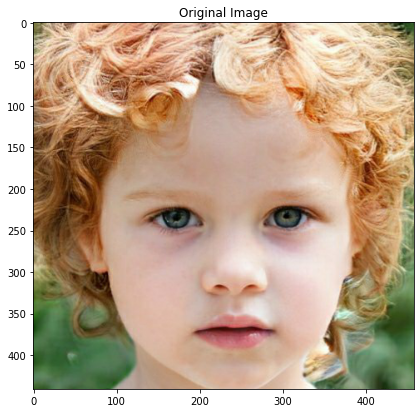

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
#from AgeProgressionFunctions import *

imgname="bonty.jpg"
originalImg=mpimg.imread('../Aging/Original/'+imgname)

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.title("Original Image") 
plt.imshow(originalImg)


Extracting Face...
Creating Embedding...
Age Progressing the image
Please Wait...


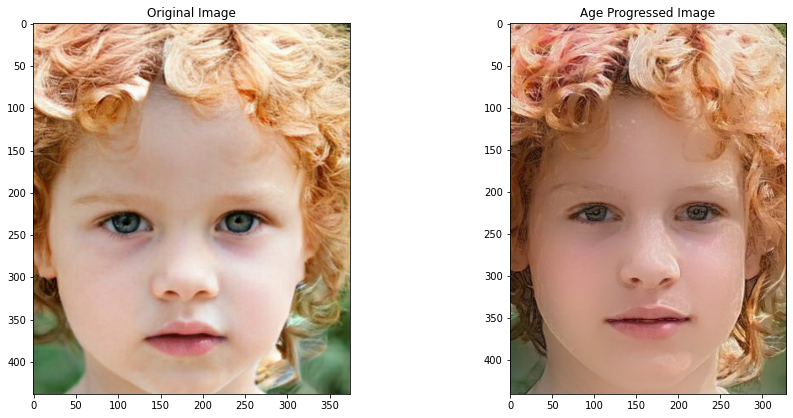

In [18]:
Result=AgeProgress(imgname)

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(2,2,1)
plt.title("Original Image") 
ax1.imshow(Result[0])
ax2 = fig.add_subplot(2,2,2)
plt.title("Age Progressed Image") 
ax2.imshow(Result[1])
